In [1]:
%%capture
import pandas as pd
import numpy as np
import gensim.downloader       
import random
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
import torch
from sklearn.decomposition import PCA
from google.colab import drive
%pip install transformers
from transformers import pipeline
import os
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import math
import matplotlib.pyplot as plt

In [2]:
ISDRIVE=False
path = ""
if ISDRIVE:
    drive.mount('/content/drive', force_remount=True)
    path = "/content/drive/MyDrive/Master Thesis/"

splits_path = path + "splits/"
dataset_path = path + "analogy_contexts_splits/"
all_embeddings_path = path + "Generation of embeddings + experiments/Data/analogy embeddings/"
cache_path = path+"cache/"
log_path = path + "Logs/"

Mounted at /content/drive


In [3]:
def read_dataset(filename):
  splitter = ";"
  data_length = 14
  with open(dataset_path + filename, 'r') as f:
    lines = f.readlines()
  items = []
  for i in range(1, len(lines), 2):
    data = lines[i].split(splitter)
    assert(len(data) == data_length)
    item1 = data[0]
    item2 = data[3]
    item3 = data[6]
    item4 = data[9]
    items.append((item1, item2, item3, item4))
  return items

In [4]:
def predict(model, dataset):
  device = torch.device('cuda:0')
  unmasker = pipeline('fill-mask', model=model, device=device)
  X = []
  y = []
  for i, row in enumerate(dataset):
    s = f"{row[0]} is to {row[1]} what [MASK] is to {row[3]}"
    X.append(s)
    y.append(row[2])
  predicted = unmasker(X)
  corrects = []
  for i, (pred, target) in enumerate(zip(predicted, y)):
    if any([prediction["token_str"].lower() == target.lower() for prediction in pred]):
      print(f"{i} of {len(dataset)}")
      corrects.append(1)
    else:
      corrects.append(0)
  return sum(corrects) / len(corrects)


In [5]:
def reset_log(log_filename):
  with open(log_path+log_filename, "w") as f:
    f.write("")
    
splitter = "; "
splitter2 = ": "

def write_line(log_filename, obj):
  s = ""
  counter = 0
  n = len(obj.keys())
  for key in obj:
    counter += 1
    s += f"{key}{splitter2}{obj[key]}"
    if counter != n:
      s += splitter
  s += "\n"
  with open(log_path+log_filename, 'a') as f:
    f.write(s)

def read_log(log_filename):
  with open(log_path+log_filename, "r") as f:
    content = f.readlines()
  objects = []
  for line in content:
    line = line.replace("\n", "").split(splitter)
    mapper = {}
    for elm in line:
      elm = elm.split(splitter2)
      assert(len(elm) == 2)
      key, value = elm[0], elm[1]
      mapper[key] = value
    objects.append(mapper)
  return objects

In [6]:
#reset_log("log_analogy.txt")

In [7]:
bert_models = [
  'prajjwal1/bert-mini',
  'prajjwal1/bert-small',
  'prajjwal1/bert-medium',
  'bert-base-uncased',
  'bert-large-uncased'
]

def run(filename):
  ds = read_dataset(filename)
  for model in  bert_models:
    print(model)
    acc = predict(model, ds)
    write_line({"model": model, "acc": acc, "filename": filename})
    print("log_analogy.txt", f"Model: {model}, acc: {acc}")


In [8]:
#run("analogy_all_en_contexts.csv.train")

In [9]:
def find_data_line(modelname):
  log_data = read_log("log_analogy.txt")
  results = list(filter(lambda obj: obj["model"] == modelname, log_data))
  assert(len(results) == 1)
  return results[0]

row = []
for model in bert_models:
  obj = find_data_line(model)
  row.append(float(obj["acc"]))

plt.figure(figsize=(6,6))
plt.xticks(ticks=[0,1,2,3,4], labels=["BERT-mini", "BERT-small", "BERT-medium", "BERT-base", "BERT-large"])
plt.plot(row, color="red")
plt.title("Analogy Masked Language Prediction - BERT")
plt.show()

AssertionError: ignored

#Vector offset embeddings

In [14]:
gpt_models = [
    'gpt2',
    'gpt2-medium',
    'gpt2-large',
    "gpt2-xl",
    "ada-002"
]
opt_models = [
    'opt-125m',
    'opt-350m',
    'opt-1.3b',
    'opt-2.7b',
    'opt-6.7b'
]

bert_models = ["BERT-Tiny", "BERT-Mini", "BERT-Small", "BERT-Medium", "BERT-Base"]

pythia_models = [
    "pythia-70m",
    "pythia-160m",
    "pythia-410m",
    "pythia-1b",
    "pythia-2.8b",
    "pythia-6.9b"
]

In [22]:
def try_load_df_cache(filename):
  assert(".pkl" in filename)
  if os.path.exists(cache_path + filename):
    return pd.read_pickle(cache_path + filename)
  return None

def write_to_df_cache(df, filename):
  df.to_pickle(cache_path + filename)  

def load_lm_embeddings(model, keys):
  embeddings = np.load(all_embeddings_path + f"{model}_analogy_embeddings.pkl", allow_pickle=True).to_numpy()
  rows = []
  indexes = []
  added = set()
  for row in embeddings:
    if row[0] in keys and row[0] not in added:
      if isinstance(row[1], list):
        rows.append(np.array(row[1]).astype(float))
      else:
        rows.append(np.array(row[1].astype(float)))
      indexes.append(row[0])
      added.add(row[0])
  rows = np.array(rows)
  indexes = np.array(indexes)
  df = pd.DataFrame(rows, index=indexes)
  return df

def load_keys(filename):
  ds = read_dataset(filename)
  keys = []
  for items in ds:
    for item in list(items):  
      keys.append(item)
  return keys

def precision_at_k_analysis(source, target, k):
  n = source.shape[0]
  corrects_cosine = []
  corrects_euclidian = []

  distances_euclidian = euclidean_distances(source, target)
  distances_euclidian = pd.DataFrame(distances_euclidian, index=source.index, columns=source.index)
  for key in distances_euclidian.index:
    distances = distances_euclidian.loc[key].sort_values(ascending=True)[:k]
    corrects_euclidian.append(1 if key in distances.index else 0)

  distances_cosine = cosine_similarity(source.values, target.values)
  distances_cosine = pd.DataFrame(distances_cosine, index=source.index, columns=source.index)
  for key in distances_cosine.index:
    distances = distances_cosine.loc[key].sort_values(ascending=False)[:k]
    corrects_cosine.append(1 if key in distances.index else 0)

  return sum(corrects_cosine) / len(corrects_cosine), sum(corrects_euclidian) / len(corrects_euclidian)

def load_embeddings(model, filename):
  keys = load_keys(filename)
  retval = None
  if model in ["BERT-Tiny", "BERT-Mini", "BERT-Small", "BERT-Medium", "BERT-Base", "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "ada-002", "t5-small", "t5-base", "t5-large", "t5-3b", "opt-125m", "opt-350m", "opt-1.3b", "opt-2.7b", "opt-6.7b", "pythia-70m","pythia-160m","pythia-410m","pythia-1b","pythia-2.8b","pythia-6.9b"]:
    retval = load_lm_embeddings(model, keys)
  if retval is None:
    raise Exception("Unknown model")
  retval = retval.sort_index()
  return retval

In [24]:
def run_experiment(filename, modelname, k):
  analogy_embeddings = load_embeddings(modelname, filename)
  ds = read_dataset(filename)
  chosen_analogies = []
  for items in ds:
    if all([item in analogy_embeddings.index for item in items]):
      chosen_analogies.append(items)

  index = []
  index_set = set()
  source_values = []
  target_values = []

  for item1, item2, item3, item4 in chosen_analogies:
    embed1, embed2, embed3, embed4 = analogy_embeddings.loc[item1], analogy_embeddings.loc[item2], analogy_embeddings.loc[item3], analogy_embeddings.loc[item4]
    if item4 not in index_set:
      pred_embed4 = embed1 - embed2 + embed3
      index.append(item4)
      index_set.add(item4)
      source_values.append(pred_embed4)
      target_values.append(embed4)

  source = pd.DataFrame(source_values, index=index)
  target = pd.DataFrame(target_values, index=index)

  test_acc_cosine, test_acc_euclidian = precision_at_k_analysis(source, target, k)
  write_line("log_analogy_vo.txt", {"model": modelname, "k": k, "acc_cosine": test_acc_cosine, "acc_euclidian": test_acc_euclidian, "filename": filename, "n": len(index_set)})

In [25]:
rerun = True
if rerun:
  reset_log("log_analogy_vo.txt")
  ks = [1,10,20,50]
  all_models = [gpt_models, opt_models, pythia_models, bert_models]
  filename = "analogy_all_en_contexts.csv.train"
  for k in ks:
    for modelnames in all_models:
      for modelname in modelnames:
        print(k, modelname)
        run_experiment(filename, modelname, k)

1 gpt2
1 gpt2-medium
1 gpt2-large
1 gpt2-xl
1 ada-002
1 opt-125m
1 opt-350m
1 opt-1.3b
1 opt-2.7b
1 opt-6.7b
1 pythia-70m
1 pythia-160m
1 pythia-410m
1 pythia-1b
1 pythia-2.8b
1 pythia-6.9b
1 BERT-Tiny
1 BERT-Mini
1 BERT-Small
1 BERT-Medium
1 BERT-Base
10 gpt2
10 gpt2-medium
10 gpt2-large
10 gpt2-xl
10 ada-002
10 opt-125m
10 opt-350m
10 opt-1.3b
10 opt-2.7b
10 opt-6.7b
10 pythia-70m
10 pythia-160m
10 pythia-410m
10 pythia-1b
10 pythia-2.8b
10 pythia-6.9b
10 BERT-Tiny
10 BERT-Mini
10 BERT-Small
10 BERT-Medium
10 BERT-Base
20 gpt2
20 gpt2-medium
20 gpt2-large
20 gpt2-xl
20 ada-002
20 opt-125m
20 opt-350m
20 opt-1.3b
20 opt-2.7b
20 opt-6.7b
20 pythia-70m
20 pythia-160m
20 pythia-410m
20 pythia-1b
20 pythia-2.8b
20 pythia-6.9b
20 BERT-Tiny
20 BERT-Mini
20 BERT-Small
20 BERT-Medium
20 BERT-Base
50 gpt2
50 gpt2-medium
50 gpt2-large
50 gpt2-xl
50 ada-002
50 opt-125m
50 opt-350m
50 opt-1.3b
50 opt-2.7b
50 opt-6.7b
50 pythia-70m
50 pythia-160m
50 pythia-410m
50 pythia-1b
50 pythia-2.8b
50 pythi

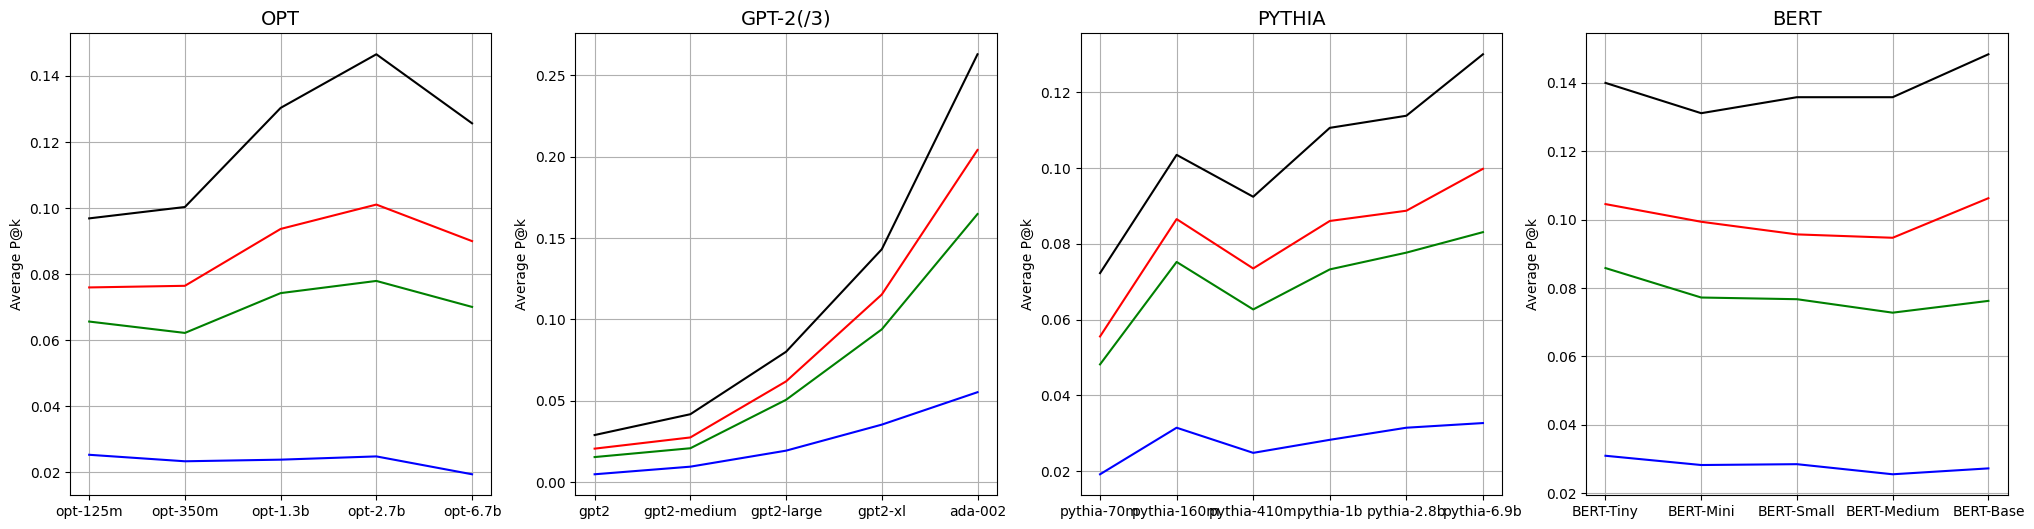

In [26]:
def generatebaseline(k, n):
  probs = 0
  for i in range(k):
      probs += 1/(n-i)
  return probs

def find_data_line(k, modelname):
  log_data = read_log("log_analogy_vo.txt")
  results = list(filter(lambda obj: obj["model"] == modelname and obj["k"] == str(k), log_data))
  assert(len(results) == 1)
  return results[0]

all_models = [opt_models, gpt_models, pythia_models, bert_models]
titles = ["OPT", "GPT-2(/3)", "PYTHIA", "BERT"]
ks = [1,10,20,50]

n_cols = 4
n_rows = 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,6))
row_counter = 0
col_counter = 0

for ax in axs:
    ax.grid()
    ax.set_ylabel("Average P@k")

for models, title in zip(all_models, titles):
  plot_baseline = False
  colors = ["b", "g", "r", "k"] # blue (k=1), green (k=10), red (k=20), black (k=50)
  ks_plotted = [1,10,20,50]
  for i, k in enumerate(ks):
    row = []
    row_baseline = []
    for model in models:
      obj = find_data_line(k, model)
      row.append(float(obj["acc_cosine"]))
      if plot_baseline:
        row_baseline.append(generatebaseline(k, int(obj["n"])))
    axs[col_counter].plot(row, c=colors[i], linestyle="solid")
    if plot_baseline:
      axs[col_counter].plot(row_baseline, colors[i][1], label=f"Baseline, K: {k}")
  if models[0] == 'gpt2':
     models[4] = 'ada-002'
  axs[col_counter].set_xticks(np.arange(len(models)), models)
  axs[col_counter].set_title(f"{title}", fontsize = 14)
  col_counter += 1
  if col_counter == n_cols:
    col_counter = 0
    row_counter += 1
path = "/content/drive/MyDrive/Master Thesis/"
plot_path = path + "Plots/"
plt.savefig(plot_path + "analogy_plots.pdf", bbox_inches='tight')
plt.show()